In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn.preprocessing as preprocessing
from IPython.core.interactiveshell import InteractiveShell
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, SelectFromModel

InteractiveShell.ast_node_interactivity = 'all'

to_show = True
to_save = False
is_sample = False
# is_sample = True
limit_rows = 1000

In [2]:
# This data cleaning part gets ideas from https://www.kaggle.com/apryor6/detailed-cleaning-visualization-python
# HAN YIKAI takes charge of feature 1-9
# official file
train_file = '../input/train_ver2.csv'
test_file = '../input/test_ver2.csv'

out_path = '../output/'


def save_df2file(data_frame: pd.DataFrame, name: str):
    data_frame.to_csv(f'{out_path}{name}.csv')

# sns.set(rc = {'figure.figsize':(20,18)})


In [3]:
df = pd.read_csv(train_file,
                 dtype={'sexo': str,
                        'ind_nuevo': str,
                        'ult_fec_cli_1t': str,
                        'indext': str},
                 # nrows=limit_rows,
                 low_memory=False
                 )
# test_df = pd.read_csv(test_file,
#                       dtype={'sexo': str,
#                              'ind_nuevo': str,
#                              'ult_fec_cli_1t': str,
#                              'indext': str},
#                       low_memory=False
#                       )
# resample the data for saving memory and shuffle the dataset
if is_sample:
    df = df.sample(frac=0.4)

df = df.drop_duplicates(['ncodpers'], keep='last')

y_name_list = list(df.iloc[:, 24:].columns)
x_name_list = list(df.iloc[:, :24].columns)
# df = df[order]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 956645 entries, 1922 to 13647308
Data columns (total 48 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   fecha_dato             956645 non-null  object 
 1   ncodpers               956645 non-null  int64  
 2   ind_empleado           949614 non-null  object 
 3   pais_residencia        949614 non-null  object 
 4   sexo                   949609 non-null  object 
 5   age                    956645 non-null  object 
 6   fecha_alta             949614 non-null  object 
 7   ind_nuevo              949614 non-null  object 
 8   antiguedad             956645 non-null  object 
 9   indrel                 949614 non-null  float64
 10  ult_fec_cli_1t         19329 non-null   object 
 11  indrel_1mes            941959 non-null  object 
 12  tiprel_1mes            941959 non-null  object 
 13  indresi                949614 non-null  object 
 14  indext                 949614 n

In [4]:
df.loc[:, y_name_list].isna().sum()

ind_ahor_fin_ult1       0
ind_aval_fin_ult1       0
ind_cco_fin_ult1        0
ind_cder_fin_ult1       0
ind_cno_fin_ult1        0
ind_ctju_fin_ult1       0
ind_ctma_fin_ult1       0
ind_ctop_fin_ult1       0
ind_ctpp_fin_ult1       0
ind_deco_fin_ult1       0
ind_deme_fin_ult1       0
ind_dela_fin_ult1       0
ind_ecue_fin_ult1       0
ind_fond_fin_ult1       0
ind_hip_fin_ult1        0
ind_plan_fin_ult1       0
ind_pres_fin_ult1       0
ind_reca_fin_ult1       0
ind_tjcr_fin_ult1       0
ind_valo_fin_ult1       0
ind_viv_fin_ult1        0
ind_nomina_ult1      5915
ind_nom_pens_ult1    5915
ind_recibo_ult1         0
dtype: int64

In [5]:
y_name_list

['ind_ahor_fin_ult1',
 'ind_aval_fin_ult1',
 'ind_cco_fin_ult1',
 'ind_cder_fin_ult1',
 'ind_cno_fin_ult1',
 'ind_ctju_fin_ult1',
 'ind_ctma_fin_ult1',
 'ind_ctop_fin_ult1',
 'ind_ctpp_fin_ult1',
 'ind_deco_fin_ult1',
 'ind_deme_fin_ult1',
 'ind_dela_fin_ult1',
 'ind_ecue_fin_ult1',
 'ind_fond_fin_ult1',
 'ind_hip_fin_ult1',
 'ind_plan_fin_ult1',
 'ind_pres_fin_ult1',
 'ind_reca_fin_ult1',
 'ind_tjcr_fin_ult1',
 'ind_valo_fin_ult1',
 'ind_viv_fin_ult1',
 'ind_nomina_ult1',
 'ind_nom_pens_ult1',
 'ind_recibo_ult1']

In [6]:
# 复用函数

# 统计缺失值的列
def cal_loss(data):
    fil = data.iloc[:, :24].isnull().any()
    loss_column = fil[fil == True].index
    res = data.loc[:, loss_column].isnull().sum()
    print(res)

#
# def renew_df(base_df: pd.DataFrame):
#     new_df = base_df
#     base_df = df.copy(deep=True)
#     return new_df

In [7]:
# 删除y空缺的行
df.drop(df[df['ind_nomina_ult1'].isnull()].index, inplace=True)

# 调整label的格式节省空间, 能节约2.1G 空间, 将近一半
df.loc[:, y_name_list] = df.loc[:, y_name_list].astype('uint8')
df.loc[:, y_name_list].value_counts(dropna=False)

/tmp/ipykernel_1498644/2941718919.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, y_name_list] = df.loc[:, y_name_list].astype('uint8')


ind_ahor_fin_ult1  ind_aval_fin_ult1  ind_cco_fin_ult1  ind_cder_fin_ult1  ind_cno_fin_ult1  ind_ctju_fin_ult1  ind_ctma_fin_ult1  ind_ctop_fin_ult1  ind_ctpp_fin_ult1  ind_deco_fin_ult1  ind_deme_fin_ult1  ind_dela_fin_ult1  ind_ecue_fin_ult1  ind_fond_fin_ult1  ind_hip_fin_ult1  ind_plan_fin_ult1  ind_pres_fin_ult1  ind_reca_fin_ult1  ind_tjcr_fin_ult1  ind_valo_fin_ult1  ind_viv_fin_ult1  ind_nomina_ult1  ind_nom_pens_ult1  ind_recibo_ult1
0                  0                  1                 0                  0                 0                  0                  0                  0                  0                  0                  0                  0                  0                  0                 0                  0                  0                  0                  0                  0                 0                0                  0                  386501
                                      0                 0                  0                 0  

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 950730 entries, 8484 to 13647308
Data columns (total 48 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   fecha_dato             950730 non-null  object 
 1   ncodpers               950730 non-null  int64  
 2   ind_empleado           949614 non-null  object 
 3   pais_residencia        949614 non-null  object 
 4   sexo                   949609 non-null  object 
 5   age                    950730 non-null  object 
 6   fecha_alta             949614 non-null  object 
 7   ind_nuevo              949614 non-null  object 
 8   antiguedad             950730 non-null  object 
 9   indrel                 949614 non-null  float64
 10  ult_fec_cli_1t         19329 non-null   object 
 11  indrel_1mes            941959 non-null  object 
 12  tiprel_1mes            941959 non-null  object 
 13  indresi                949614 non-null  object 
 14  indext                 949614 n

In [9]:
# fecha_dato 日期
# ncodpers 客户代码
# ind_empleado 员工
# pais_residencia 国藉
# sexo 性别,
# age 年龄
# fecha_alta 注册日期,
# ind_nuevo 新的,
# antiguedad 客户资历,
# indrel 最后访问日期, 一个月indrel
# ult_fec_cli_1t  作为主要客户的日期
# indrel_1mes  1 (First/Primary customer), 2 (co-owner ),P (Potential),3 (former primary), 4(former co-owner)
# tiprel_1mes  月初客户关系类型 A (active), I (inactive), P (former customer 前客户),R (Potential 潜在客户)
# indresi 居住指数S (Yes) 银行和居住国相同 N (No) 不同国家
# indext  外国人指数, S 本国出生, N 非本国
# conyuemp 配偶指数, S 客户是员工配偶
# canal_entrada
# indfall
# tipodom
# cod_prov 省份编码
# nomprov 省份名称
# ind_actividad_cliente
# renta 家庭总收入
# segmento segmentation: 01 - VIP, 02 - Individuals 03 - college graduated

In [10]:
# cal_loss(df)

In [11]:
# 删除27734条空行, 所有全空
df.drop(df[df['ind_empleado'].isnull()].index, inplace=True)
# 删除全other的空行, 所有全空
df.drop(df[df['pais_residencia'] == 'others'].index, inplace=True)

In [12]:
# 缺失值很少的删除行
df.drop(df[df['sexo'].isnull()].index, inplace=True)
df.drop(df[df['tipodom'].isnull()].index, inplace=True)

In [13]:
# 缺失值很多的删除列
df.drop('ult_fec_cli_1t', axis=1, inplace=True)
df.drop('conyuemp', axis=1, inplace=True)

In [14]:
# 省份名称直接删除, 省份编码缺失值用-1填充
df.drop('nomprov', axis=1, inplace=True)
df.cod_prov.fillna(-1, inplace=True)

In [15]:
# canal_entrada 用户加入渠道非常多162种 而且比较平衡, 还是用unknown填充, 考虑KNN填充
df.canal_entrada.value_counts()
df.canal_entrada.fillna('unknown', inplace=True)

KHE    254201
KAT    208365
KFC    203005
KHQ     76219
KHM     33215
        ...  
KHR         1
KDL         1
KDB         1
KDI         1
KGN         1
Name: canal_entrada, Length: 162, dtype: int64

In [16]:
df.indrel_1mes.fillna('unknown', inplace=True)
df.tiprel_1mes.fillna('unknown', inplace=True)

In [17]:
# 23. segmento : 01 - VIP, 02 - 个人 03 - 大学毕业
df.segmento.fillna('00', inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 949609 entries, 3777108 to 13647308
Data columns (total 45 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   fecha_dato             949609 non-null  object 
 1   ncodpers               949609 non-null  int64  
 2   ind_empleado           949609 non-null  object 
 3   pais_residencia        949609 non-null  object 
 4   sexo                   949609 non-null  object 
 5   age                    949609 non-null  object 
 6   fecha_alta             949609 non-null  object 
 7   ind_nuevo              949609 non-null  object 
 8   antiguedad             949609 non-null  object 
 9   indrel                 949609 non-null  float64
 10  indrel_1mes            949609 non-null  object 
 11  tiprel_1mes            949609 non-null  object 
 12  indresi                949609 non-null  object 
 13  indext                 949609 non-null  object 
 14  canal_entrada          94960

In [19]:
cal_loss(df)

renta    240201
dtype: int64


# 编码

In [20]:
# 0. fecha_dato 日期
# df.fecha_dato.value_counts(dropna=False).plot(kind='bar')
# 1. ncodpers 客户代码, 弃用
# df.ncodpers.value_counts(dropna=False)

In [21]:
# 日期和客户代码删除
df.drop(['fecha_dato', 'ncodpers'], axis=1, inplace=True)

In [22]:
def label_enc(data):
    label_enc = preprocessing.LabelEncoder()  #获取一个LabelEncoder
    # label_enc = preprocessing.OrdinalEncoder()  #获取一个LabelEncoder
    label_data = label_enc.fit_transform(data)
    return np.array(label_data).reshape(-1, 1)


# def concat_encoder(df):
#     data = pd.concat([data, pd.DataFrame(arrays, columns=names)],axis=1)
#     data = data.drop(['hour'],axis=1)
#     return df

# 对单列编码
def oh_enc(data):
    label_data = label_enc(data)
    # 2. 再用onehot
    oh_enc = preprocessing.OneHotEncoder()
    name_list = []
    for i in range(label_data.classes_.shape[0]):
        name = f'{data.name}_{i}'
        name_list.append(name)
    # 给fit_transform传递的X一定要是 2D的，即（samples，features），否则会报错`
    onehot_data = oh_enc.fit_transform(label_data)
    # 转成numpy array格式
    onehot_data = onehot_data.toarray()
    enc_df = pd.DataFrame(onehot_data, columns=name_list)
    return enc_df

In [23]:
# 2. 5 ind_empleado 员工指标,
# 树模型直接不处理
# A active 活跃, B ex employed 前雇员, F filial 子女, N not employee 非雇员, P pasive 被动, 目前没有寻找新工作, 但是对新工作持开放态度

# df.ind_empleado.value_counts(dropna=False)
# enc_array = label_enc(df.ind_empleado)
def get_ordinal_name(data) -> list:
    return [f'{data.name}_enc']


def get_onehot_name(data) -> list:
    length = data.unique().shape[0]
    l = []
    for i in range(length):
        l.append(f'{data.name}_oh_{i}')
    return l


def new_ordinal_df(data: pd.Series, array):
    name: list = get_ordinal_name(data)
    return pd.DataFrame(array, index=data.index, columns=name)


# TODO
def new_onehot_df(data: pd.Series, array):
    name: list = get_ordinal_name(data)
    return pd.DataFrame(array, index=data.index, columns=name)


# TODO
def show_value_counts(df, od_set: set, oh_set: set):
    df[get_ordinal_name(df.ind_empleado)].value_counts(dropna=False)


od_set = set()
oh_set = set()

In [24]:
l = get_onehot_name(df.ind_empleado)
e = get_ordinal_name(df.ind_empleado)
l
e

['ind_empleado_oh_0',
 'ind_empleado_oh_1',
 'ind_empleado_oh_2',
 'ind_empleado_oh_3',
 'ind_empleado_oh_4']

['ind_empleado_enc']

In [25]:
# df.drop(get_ordinal_name(df.ind_empleado), axis=1, inplace=True)

In [26]:
# df[get_ordinal_name(df.ind_empleado)].value_counts()

df.ind_empleado.value_counts(dropna=False)

N    949089
B       219
F       152
A       148
S         1
Name: ind_empleado, dtype: int64

In [27]:
# 单列编码
# df = pd.concat([df, new_ordinal_df(df.ind_empleado, label_enc(df.ind_empleado))], axis=1)
# df[get_ordinal_name(df.ind_empleado)].value_counts(dropna=False)

# 用list收集, 统一进行编码处理
od_set.add(df.ind_empleado.name)

In [28]:
# 3. 118 pais_residencia 客户国籍 ES占比巨大
# 发现others国家的人所有数据都是others
# 继续处理
# Nan unknown
# TODO 计算占比
# df.pais_residencia.value_counts(dropna=False)
# df.pais_residencia.unique()

# 用others替换其他
df.loc[(df['pais_residencia'] != 'ES'), 'pais_residencia'] = 'others'

# df[df['pais_residencia']=='ES'].sum()
df.pais_residencia.value_counts(dropna=False)

od_set.add(df.pais_residencia.name)

ES        945592
others      4017
Name: pais_residencia, dtype: int64

In [29]:
# 4. sexo
# Nan = unknown
# 无序类别
df.sexo.value_counts(dropna=False)
od_set.add(df.sexo.name)

V    515572
H    434037
Name: sexo, dtype: int64

In [30]:
def sd_scale(data):
    scaler = preprocessing.StandardScaler()
    data = np.array(data).reshape(-1, 1)
    return scaler.fit_transform(data)


def mm_scale(data):
    scaler = preprocessing.MinMaxScaler()
    data = np.array(data).reshape(-1, 1)
    return scaler.fit_transform(data)


In [31]:
# 5. age 年龄
df.age = df.age.astype('int8')

# 清洗>100和<18的异常值, 西班牙银行18岁可以开户
df.loc[df.age < 18, "age"] = df.loc[(df.age >= 18) & (df.age <= 30), "age"].mean(skipna=True)
df.loc[df.age > 100, "age"] = df.loc[(df.age >= 30) & (df.age <= 100), "age"].mean(skipna=True)
df["age"].fillna(df["age"].mean(), inplace=True)
# df.age.value_counts(dropna=False)


In [32]:
df.age.isna().sum()
df.renta.isna().sum()
# cal_loss(df)

0

240201

Text(-15.690694444444444, 0.5, 'Count')

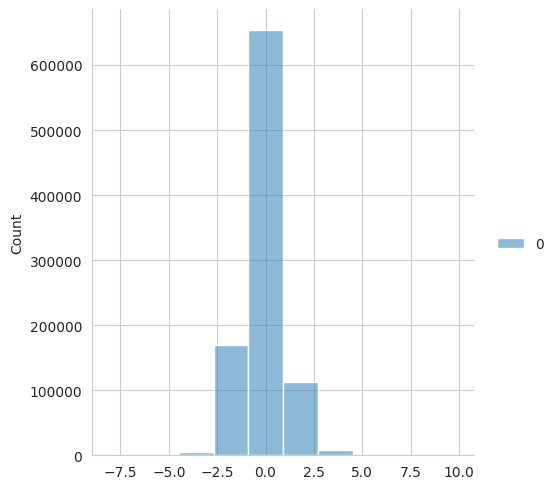

In [33]:
# TODO renta 数值型填充
# TODO
df.renta.fillna(df.renta.mean(), inplace=True)
df.renta = round(df.renta)
df.renta = df.renta.astype('int32')
# sns.scatterplot(df.renta, df.renta.value_counts())
# df.renta.plot.scatter(x='renta', y=df.renta.value_counts())
sns.set_style("whitegrid")

data = np.log(df.renta)
data = sd_scale(data)
df['log_renta'] = data
sns.displot(data,
            bins=10,
            kde=False,
            color="tomato")
plt.ylabel("Count")

In [34]:
round(data.min(), 2)
round(data.mean(), 2)
round(data.max(), 2)
data.shape

-8.08

-0.0

9.9

(949609, 1)

In [35]:
df.fecha_alta.value_counts(dropna=False)

2014-07-28    3469
2014-10-03    3424
2014-08-04    2821
2013-10-14    2654
2013-08-03    2028
              ... 
2010-09-19       1
2010-12-11       1
2012-12-08       1
2012-02-12       1
2014-12-13       1
Name: fecha_alta, Length: 6756, dtype: int64

In [36]:
pd.DatetimeIndex(df["fecha_alta"]).month.value_counts()

10    156186
9     111533
11    108305
7      98077
8      92289
12     71216
1      60021
2      54629
3      53819
4      51182
5      48497
6      43855
Name: fecha_alta, dtype: int64

In [37]:
temp = df.fecha_alta.astype('datetime64[M]')
temp.value_counts()

2015-10-01    28120
2013-10-01    24295
2015-09-01    23281
2014-10-01    22223
2012-10-01    19412
              ...  
1995-08-01      243
1995-04-01      137
1995-03-01      107
1995-01-01       78
1995-02-01       69
Name: fecha_alta, Length: 257, dtype: int64

In [38]:
df.antiguedad.value_counts(dropna=False)
od_set.add(df.antiguedad.name)

      7    26931
     31    24217
      8    23238
     19    21836
     10    20638
           ...  
    253      151
    256      102
    254       85
    255       77
-999999        3
Name: antiguedad, Length: 258, dtype: int64

In [39]:
df.fecha_alta.info()

<class 'pandas.core.series.Series'>
Int64Index: 949609 entries, 3777108 to 13647308
Series name: fecha_alta
Non-Null Count   Dtype 
--------------   ----- 
949609 non-null  object
dtypes: object(1)
memory usage: 14.5+ MB


In [40]:
x = pd.to_datetime(df.fecha_alta)
x.info()

<class 'pandas.core.series.Series'>
Int64Index: 949609 entries, 3777108 to 13647308
Series name: fecha_alta
Non-Null Count   Dtype         
--------------   -----         
949609 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 14.5 MB


In [41]:
# 6.fecha_alta 客户首次签订合同的日期, 可以用距今差值表示, 总结成月份, 然后判断和 antiguedad客户资历的关系
df.antiguedad.value_counts(dropna=False)
df.antiguedad.info()

# TODO 暂时先删除
df.drop('fecha_alta', inplace=True, axis=1)
# df.fecha_alta.isnull().sum()
# months_active = df.loc[df["ind_nuevo"].isnull(), :].groupby("ncodpers", sort=False).size()
# months_active.max()

      7    26931
     31    24217
      8    23238
     19    21836
     10    20638
           ...  
    253      151
    256      102
    254       85
    255       77
-999999        3
Name: antiguedad, Length: 258, dtype: int64

<class 'pandas.core.series.Series'>
Int64Index: 949609 entries, 3777108 to 13647308
Series name: antiguedad
Non-Null Count   Dtype 
--------------   ----- 
949609 non-null  object
dtypes: object(1)
memory usage: 14.5+ MB


In [42]:

# 7.ind_nuevo 新客户指数 2. 如果是6个月内注册的客户, 则为1
df.ind_nuevo = df.ind_nuevo.astype('int8')
df.ind_nuevo.value_counts(dropna=False)

od_set.add(df.ind_nuevo.name)

0    906388
1     43221
Name: ind_nuevo, dtype: int64

In [43]:
# 8. antiguedad 客户资历, 单位是月
df.antiguedad.value_counts(dropna=False)
od_set.add(df.antiguedad.name)

      7    26931
     31    24217
      8    23238
     19    21836
     10    20638
           ...  
    253      151
    256      102
    254       85
    255       77
-999999        3
Name: antiguedad, Length: 258, dtype: int64

In [44]:
# 6,7,8 缺失值数量相等已经删除

In [45]:
# 9.indrel  2:  1表示primary, 99表示当月primary,但不是月末?
# Nan =unknown
# one-hot label编码?
df.indrel = df.indrel.astype('int8')
df.indrel.value_counts(dropna=False)
od_set.add(df.indrel.name)

1     930280
99     19329
Name: indrel, dtype: int64

In [46]:
# 10. ult_fec_cli_1t 作为主要客户的日期
# 缺失值太多, 丢弃
# df.ult_fec_cli_1t.value_counts(dropna=False)
# df.ult_fec_cli_1t.isnull().sum()

In [47]:
# df.replace('unknown', -2, inplace=True)
# df.replace('P', -3, inplace=True)
# 必须先修改类型, 不然replace匹配不上
# df.indrel_1mes = df.indrel_1mes.astype('float')
df.indrel_1mes.replace({'1.0': '1', '2.0': '2', '3.0': '3', '4.0': '4'}, inplace=True)  # 不同key用不同value替换
df.indrel_1mes.value_counts(dropna=False)
od_set.add(df.indrel_1mes.name)

1          940938
unknown      7655
3             747
2             131
P             101
4              37
Name: indrel_1mes, dtype: int64

In [48]:
# 12.tiprel_1mes 月初客户关系类型 A (active), I (inactive), P (former customer 前客户),R (Potential 潜在客户)
# Nan = unknown
# label 编码
df.tiprel_1mes.value_counts(dropna=False)
od_set.add(df.tiprel_1mes.name)

I          540967
A          400102
unknown      7655
P             784
R             101
Name: tiprel_1mes, dtype: int64

In [49]:
# 13. indresi 居住指数S (Yes) 银行和居住国相同 N (No) 不同国家
# label编码, S=1, N=0
df.indresi.value_counts(dropna=False)
od_set.add(df.indresi.name)


S    945592
N      4017
Name: indresi, dtype: int64

In [50]:
# 14. indext 外国人指数, S 本国出生, N 非本国
# label 编码
df.indext.value_counts(dropna=False)
od_set.add(df.indext.name)


N    902019
S     47590
Name: indext, dtype: int64

In [51]:
# 15. conyuemp 配偶指数, S 客户是员工配偶
# 缺失太多, 删除列
# df.conyuemp.value_counts(dropna=False)

In [52]:
# 16. canal_entrada	客户渠道 (拉新渠道)
# Nan = unknown, 占比小于3%都是other
# 用占比, 占比低的作为others
df.canal_entrada.value_counts(dropna=False)
# df.canal_entrada.isnull().sum()
# print(100 * round(df.canal_entrada.value_counts(dropna=False) / df.shape[0], 8))
od_set.add(df.canal_entrada.name)

KHE    254201
KAT    208365
KFC    203005
KHQ     76219
KHM     33215
        ...  
025         1
KHR         1
KDB         1
KDI         1
KGN         1
Name: canal_entrada, Length: 163, dtype: int64

In [53]:
# 17. indfall 已故索引 N/S
df.indfall.value_counts(dropna=False)
od_set.add(df.indfall.name)


N    946879
S      2730
Name: indfall, dtype: int64

In [54]:
# 18. tipodom 地址类型. 1, primary address 弃用
# Nan dropna
# 没有区分度, 删除列
# label编码
df.tipodom.value_counts(dropna=False)
df.drop('tipodom', axis=1, inplace=True)

1.0    949609
Name: tipodom, dtype: int64

In [55]:
# 19.cod_prov 省份编码
# 转成int
# Nan = 0?
# number
df.cod_prov = df.cod_prov.astype('int8')
df.cod_prov.value_counts(dropna=False)
od_set.add(df.cod_prov.name)


 28    304572
 8      90484
 46     49028
 41     41366
 15     29271
 30     28226
 29     25096
 50     23563
 3      22761
 11     20209
 36     19270
 33     18707
 35     16730
 47     16339
 6      13191
 45     12952
 48     12799
 18     12687
 37     11280
 39     11062
 14     10052
 7       9402
 10      8740
 13      8241
 21      8186
 2       7956
 43      7827
 12      7323
 9       6786
 17      6447
 31      6143
 26      5913
 24      5871
 27      5759
 32      5712
 25      5523
 38      5313
 20      5000
 19      4810
 23      4629
 4       4451
-1       4018
 16      3861
 49      3477
 34      3405
 40      2939
 22      2845
 5       2679
 1       2668
 44      1574
 42      1284
 52       654
 51       528
Name: cod_prov, dtype: int64

In [56]:
# 20. nomprov 省份名称 删除
# df.nomprov.value_counts(dropna=False)

In [57]:
# 21. ind_actividad_cliente	活跃指数 1, active customer; 0, inactive customer)
df.ind_actividad_cliente = df.ind_actividad_cliente.astype('int8')
df.ind_actividad_cliente.value_counts(dropna=False)
od_set.add(df.ind_actividad_cliente.name)


0    552638
1    396971
Name: ind_actividad_cliente, dtype: int64

In [58]:
# 23. segmento : 01 - VIP, 02 - 个人 03 - 大学毕业
# Nan = unknown
# ordinal 编码
df.segmento.value_counts()
od_set.add(df.segmento.name)


02 - PARTICULARES     551435
03 - UNIVERSITARIO    350480
01 - TOP               36009
00                     11685
Name: segmento, dtype: int64

In [59]:
# 未编码的列, 就是数值特征
continuous_set = set(df.columns) - od_set - oh_set - set(y_name_list)
# 数值集合
continuous_set
# 序号编码
od_set
# onehot编码
oh_set

{'age', 'log_renta', 'renta'}

{'antiguedad',
 'canal_entrada',
 'cod_prov',
 'ind_actividad_cliente',
 'ind_empleado',
 'ind_nuevo',
 'indext',
 'indfall',
 'indrel',
 'indrel_1mes',
 'indresi',
 'pais_residencia',
 'segmento',
 'sexo',
 'tiprel_1mes'}

set()

In [60]:
from sklearn.preprocessing import QuantileTransformer

# QuantileTransformer(df.age, n_quantiles=300, output_distribution='normal', random_state=0)


In [61]:
# 编码流程
len(od_set)


15

In [62]:
finished = []
for name in od_set:
    print(name)
    df = pd.concat([df, new_ordinal_df(df[name], label_enc(df[name]))], axis=1)
    finished.append(name)
df.drop(finished, inplace=True, axis=1)


pais_residencia
indresi
cod_prov
ind_empleado
indrel
indext
indrel_1mes
indfall
sexo
tiprel_1mes
segmento
antiguedad
ind_actividad_cliente
ind_nuevo
canal_entrada


In [63]:
# 删除原renta, 保留log_renta
df.drop('renta', axis=1, inplace=True)

In [64]:
X = df.drop(y_name_list, axis=1)
y = df.loc[:, y_name_list]
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3)


# 特征筛选

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

<Figure size 5000x3000 with 0 Axes>

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 5000x3000 with 0 Axes>

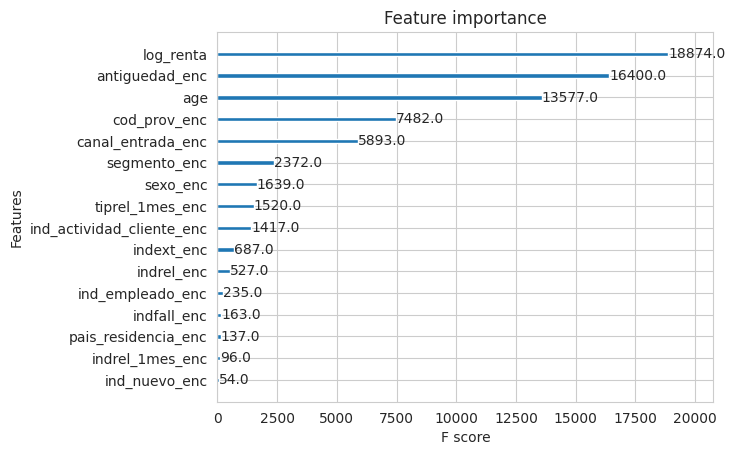

In [65]:
# 模型嵌入
import xgboost

xb = xgboost.XGBClassifier()
xb.fit(Xtrain, Ytrain)

plt.figure(figsize=(50, 30))
selected_features = xb.feature_importances_
xgboost.plot_importance(xb)
plt.show()

In [66]:

importance = xb.get_booster().get_score()
importance_dict = sorted(importance.items(), key=lambda k: k[1], reverse=True)
importance_dict

[('log_renta', 18874.0),
 ('antiguedad_enc', 16400.0),
 ('age', 13577.0),
 ('cod_prov_enc', 7482.0),
 ('canal_entrada_enc', 5893.0),
 ('segmento_enc', 2372.0),
 ('sexo_enc', 1639.0),
 ('tiprel_1mes_enc', 1520.0),
 ('ind_actividad_cliente_enc', 1417.0),
 ('indext_enc', 687.0),
 ('indrel_enc', 527.0),
 ('ind_empleado_enc', 235.0),
 ('indfall_enc', 163.0),
 ('pais_residencia_enc', 137.0),
 ('indrel_1mes_enc', 96.0),
 ('ind_nuevo_enc', 54.0)]

In [67]:
for i in Xtrain.columns.to_list():
    if i not in [im[0] for im in importance_dict]:
        print(i)

indresi_enc


# Filter

In [68]:
from sklearn.feature_selection import VarianceThreshold
X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_new=sel.fit_transform(X)
print(X_new)

[[0 1]
 [1 0]
 [0 0]
 [1 1]
 [1 0]
 [1 1]]


# 模型搭建

In [69]:

from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import plot_roc_curve

import sklearn.metrics as metrics


def print_evaluation(y_true, y_pred, target_names=None, average='micro'):
    acc = metrics.accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)

    # precision = metrics.precision_score(y_true, y_pred, average=average)
    # metrics.recall_score(y_true, y_pred, average=average)
    # metrics.f1_score(y_true, y_pred, average=average)

    # 统一precision+recall+f1
    prf = metrics.precision_recall_fscore_support(y_true, y_pred, average=average)
    hamming = metrics.hamming_loss(y_true, y_pred)
    # kappa不支持多标签
    # kappa = metrics.cohen_kappa_score(y_true, y_pred)

    print(f"acc \n{acc}")
    print(f"report \n{report}")
    print(f'precision_recall_fscore_support\n{prf}\n')
    # print(f'multilabel_confusion_matrix\n{confusion_mat}')
    # print(f'auc\n{auc}')
    print(f'hamming\n{hamming}\n')
    # print(f'kappa\n{kappa}\n')


# 混淆矩阵
def show_matrix(y_true, y_pred):
    fig = plt.figure(figsize=(16, 20))

    mat = metrics.multilabel_confusion_matrix(y_true, y_pred)
    for i in range(24):
        ax = fig.add_subplot(6, 4, i + 1)
        sns.heatmap(mat[i], annot=True, fmt='.20g', ax=ax)
        ax.set_title(f'{Ytest.iloc[:, i].name}')
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        # point = int(f'9{left}{right}')
        # print(point)
        # f.add_subplot(point)
        # break
    # plt.tight_layout()
    plt.show();


# roc曲线绘制
def show_roc(y_true, y_proba, plot=True):
    plt.figure(figsize=(5, 5), dpi=100)
    aucs = []
    for c in range(y_true.shape[1]):
        if y_proba[c].shape[0] == 24:
            fpr, tpr, thresholds = metrics.roc_curve(np.array(y_true.iloc[:, c]).ravel(), y_proba[:, c].ravel())
        else:
            fpr, tpr, thresholds = metrics.roc_curve(np.array(y_true.iloc[:, c]).ravel(),
                                                     y_proba[c][:, 1].ravel())
        auc = metrics.auc(fpr, tpr)
        if plot:
            plt.plot(fpr, tpr, label='AUC = %0.2f')  #生成ROC曲线
        # g = sns.FacetGrid(tips, col='time', row='smoker')  # 按行和列的分类做N个图
        # g.map(plt.hist, 'total_bill', bins=10)  # 指定做图方式
        # break
        print(f'auc : {auc}')
        aucs.append(auc)
    avg_auc = f'average auc {np.mean(aucs)}'
    # print(avg_auc)
    if plot:
        plt.show();
    return np.mean(aucs)

# print_evaluation(Yvalidation, y_pred, average='micro')


In [79]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# GBDT
cpu_threads = 18
gbdt = GradientBoostingClassifier(
    n_estimators=100,  # 树的数量
    max_depth=8,  # 树的最大深度
    ccp_alpha=0.0,
    criterion='gini',  # gini, entropy, log_loss
    init=None,
    learning_rate=0.1,
    loss='deviance',
    max_features=10,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_iter_no_change=None,
    random_state=None,
    subsample=1.0,
    tol=0.0001,
    validation_fraction=0.1,
    verbose=0,
    warm_start=False
)
# RF
rfc = RandomForestClassifier(
    n_estimators=150,  # 树的个数
    criterion='gini',  #
    max_depth=10,  # 最大深度
    min_samples_split=50,  # 样本最小分裂
    min_samples_leaf=10,  # 叶子最小样本数
    max_features='sqrt',
    max_leaf_nodes=None,
    n_jobs=-1,
    # 以下是不重要参数
    min_impurity_decrease=0.0,
    min_weight_fraction_leaf=0.0,
    bootstrap=True,
    oob_score=False,
    random_state=0,
    verbose=1,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)

knn = KNeighborsClassifier(
    n_neighbors=Ytrain.shape[1],  # k的个数
    weights="distance",  # distance, uniform, callable 权重判断方式
    n_jobs=cpu_threads,
    algorithm='auto',
    p=2,  # 明可夫距离, 2就是欧式距离, >=3 其他明氏距离
)

svc = OneVsRestClassifier(
    LinearSVC(
        C='',
        # kernel='RBF'
    ),
    n_jobs=cpu_threads
)

lr = OneVsRestClassifier(LogisticRegression(
    penalty='l2',  # 正则项, l1, l2
    solver='sag',  # 最优化求解方法 liblinear, newton-cg, lbfgs, sag
    class_weight='auto',  # 类别权重
    # sample_weight = 'auto', # 样本权重, 最终权重是类别权重*样本权重
    n_jobs=cpu_threads,
    multi_class='ovr',  # multinomial, ovr, 多类别ovr和mvm
    # 以下不常用
    dual=False,  # 对偶或者原始方法。Dual只适用于正则化相为l2的‘liblinear’的情况，通常样本数大于特征数的情况下，默认为False。
    fit_intercept=True,  # 是否存在截距，默认存在。
    intercept_scaling=1,  # 仅在正则化项为‘liblinear’，且fit_intercept设置为True时有用。
    max_iter=20,  # 算法收敛的最大迭代次数。
    tol=0.0001,  # 迭代终止判据的误差范围。
    verbose=0,  # 日志冗长度int：冗长度；0：不输出训练过程；1：偶尔输出； >1：对每个子模型都输出
    warm_start=False,  # 是否热启动，如果是，则下一次训练是以追加树的形式进行（重新使用上一次的调用作为初始化）。布尔型，默认False。
))

# XGBoost
xgb = XGBClassifier(
    booster='gbtree',  # gbtree, gblinear, dart选择模型, 常用树模型, 性能好
    num_class=Ytrain.shape[1],
    n_estimators=200,  # 生成的最大树的数目，也是最大的迭代次数
    max_depth=5,  # 最大深度 3-10常用
    max_leaves=100,
    learning_rate=0.1,  #学习率, 0.01-0.3
    objective='multi:logloss',  # 目标

    verbosity=1,
    tree_method='auto',
    # 正则化
    reg_alpha=0.1,  # l1正则参数
    reg_lambda=0.4,  # l2正则参数
    min_child_weight=5,
    max_delta_step=0,
    subsample=0.8,
    # n_jobs=cpu_threads,
    colsample_bytree=0.7,
    # scale_pos_weight=0.8,
    # eval_metric='auc',
    seed=0,
    gamma=0,
    random_state=0,
    # 在节点分裂时，只有分裂后损失函数的值下降了，才会分裂这个节点。gamma指定了节点分裂所需的最小损失函数下降值。 这个参数的值越大，算法越保守。因为gamma值越大的时候，损失函数下降更多才可以分裂节点。所以树生成的时候更不容易分裂节点。范围: [0,∞]
)
        # , n_jobs=-1)

# LightGBM
lgb = OneVsRestClassifier(LGBMClassifier(
    # 先固定的参数
    boosting_type='gbdt',  # gbdt, rf, dart, goss
    objective='multiclass',
    # regression，使用L2正则项的回归模型
    # regression_l1，使用L1正则项的回归模型。
    # mape，平均绝对百分比误差。
    # binary，二分类。
    # multiclass，多分类
    num_class=24,  # 多分类类别数
    n_estimators=50,  # 子树数量
    learning_rate=0.1,  # 学习率
    metric='multi_logloss',
    num_leaves=150,  # 单颗树的叶子数, 对模型影响很大
    min_child_samples=50,  # 叶节点样本的最少数量, 防止过拟合
    min_child_weight=1,  # 指定孩子节点中最小的样本权重和，如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束，默认值为1。
    min_split_gain=0,  # 增大会使树变矮, 指定叶节点进行分支所需的损失减少的最小值，默认值为0。设置的值越大，模型就越保守。
    # 需要调节的参数
    max_depth=5,
    # num_leaves=200,  # 叶子数量, 应该小于 2^max_depth
    # 评估指标
    subsample=1,  # 行采样, 小于1就有一部分不会被采样, 防止过拟合, 需要bagging_freq=0生效
    bagging_freq=0,  # 生效subsample
    # 正则化
    reg_alpha=0,  # l1正则
    reg_lambda=0.3,  # l2正则系数
    # 以下不常用
    # subsample_for_bin=200000,
    # feature_fraction=1,  # 对特征随机采样的比例, 列采样
    random_state=0,
    # class_weight='is_unbalance', # 类别权重
    # subsample_freq=

), n_jobs=-1
)

models = {'rfc': rfc, 'gbdt': gbdt}
models
pred_dict = {}
# for name, model in models.items():
#     model.fit(Xtrain, Ytrain)
#     # y_pred = model.predict(Xvalidation)
#     # gbm.fit(Xtrain, Ytrain, eval_set=[(Xvalidation, Yvalidation)], eval_metric='l1', early_stopping_rounds=5)
#
# for name, m in models.items():
#     m.fit(Xtrain, Ytrain)
#     y_pred = m.predict(Xvalidation)
#     y_pred_proba = m.predict_proba(Xvalidation)
#     pred_dict[name] = (y_pred, y_pred_proba)

{'rfc': RandomForestClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=50,
                        n_estimators=150, n_jobs=-1, random_state=0, verbose=1),
 'gbdt': GradientBoostingClassifier(criterion='gini', loss='deviance', max_depth=8,
                            max_features=10)}

In [80]:
from sklearn.model_selection import KFold, LeaveOneOut, LeavePOut

cv = False
# cv = True
kf = KFold(n_splits=6, shuffle=True, random_state=0)
if cv:
    train_auc_list = []
    validation_auc_list = []
    for train_index, validation_index in kf.split(X=Xtrain, y=Ytrain):
        train_x = Xtrain.iloc[train_index]
        train_y = Ytrain.iloc[train_index]
        validation_x = Xtrain.iloc[validation_index]
        validation_y = Ytrain.iloc[validation_index]
        print(f'训练集 x {train_x.shape} y {train_y.shape}\n验证集 x {validation_x.shape} y {validation_y.shape}')
        # train
        m = rfc
        # m.fit(train, validation)
        # y_pred_proba = m.predict_proba(train)
        # train_pred_proba = m.predict_proba(Xtrain)
        # train_auc_list.append(show_roc(Ytrain, train_pred_proba, False))
        # validation_auc_list.append(show_roc(Yvalidation, y_pred_proba, False))
        # train_auc_list.append(show_roc())
    print(f'训练平均auc {np.mean(train_auc_list)}')
    print(f'验证平均auc {np.mean(validation_auc_list)}')
else:
    m = rfc
    m.fit(Xtrain, Ytrain)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished


RandomForestClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=50,
                       n_estimators=150, n_jobs=-1, random_state=0, verbose=1)

In [81]:
if not cv:
    y_pred = m.predict(Xtest)
    y_pred_proba = m.predict_proba(Xtest)
    train_pred = m.predict(Xtrain)
    train_pred_proba = m.predict_proba(Xtrain)

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=20)]: Done 150 out of 150 | elapsed:   27.8s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=20)]: Done 150 out of 150 | elapsed:   28.1s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    8.0s
[Parallel(n_jobs=20)]: Done 150 out of 150 | elapsed:  1.1min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    7.6s
[Parallel(n_jobs=20)]: Done 150 out of 150 | elapsed:  1.1min finished


In [73]:
# bst = xgb.Booster()
# bst.load_model('xgb.model')
# plot
# xgboost.to_graphviz(xgb)
# plot_tree(bst,fmap='', num_trees=0, rankdir='UT', ax=None)
# plt.show()

In [74]:
# 验证集
print_evaluation(y_true=Ytest, y_pred=y_pred)


/home/lucas/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lucas/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lucas/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


acc 
0.5617850134967689
report 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.00      0.00      0.00         1
           2       0.77      0.85      0.80    168709
           3       0.00      0.00      0.00        84
           4       0.64      0.02      0.04     22006
           5       0.99      0.79      0.88      2227
           6       0.90      0.03      0.07      2399
           7       0.68      0.13      0.22     30135
           8       0.00      0.00      0.00      9976
           9       0.00      0.00      0.00        95
          10       0.00      0.00      0.00       319
          11       0.65      0.09      0.16      9388
          12       0.61      0.13      0.21     22793
          13       0.00      0.00      0.00      4397
          14       0.00      0.00      0.00      1309
          15       0.00      0.00      0.00      2232
          16       0.00      0.00      0.00      

In [75]:
# 训练集
print_evaluation(Ytrain, train_pred)

/home/lucas/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lucas/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lucas/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


acc 
0.5631508320721621
report 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        15
           2       0.77      0.85      0.80    393101
           3       0.00      0.00      0.00       232
           4       0.68      0.02      0.04     51061
           5       1.00      0.79      0.88      5360
           6       0.84      0.04      0.08      5698
           7       0.69      0.13      0.22     70468
           8       0.00      0.00      0.00     23298
           9       0.00      0.00      0.00       223
          10       0.00      0.00      0.00       702
          11       0.67      0.10      0.17     21830
          12       0.63      0.13      0.22     53073
          13       0.00      0.00      0.00     10291
          14       0.00      0.00      0.00      3218
          15       0.00      0.00      0.00      5127
          16       0.00      0.00      0.00      

In [76]:
train_pred_proba.shape
y_pred_proba.shape
Ytrain.shape
Ytest.shape

AttributeError: 'list' object has no attribute 'shape'

auc : 0.8745932767799156
auc : 0.869282720565006
auc : 0.8090192898537841
auc : 0.9066730897429917
auc : 0.8935302105950305
auc : 0.9996837840615957
auc : 0.97412456856646
auc : 0.9280562013884537
auc : 0.9228849978744288
auc : 0.9328318645892085
auc : 0.9327279826071928
auc : 0.9465987078315776
auc : 0.8980180514792002
auc : 0.9375354917566965
auc : 0.9549843532985811
auc : 0.9369983071439507
auc : 0.9611710762144081
auc : 0.8815218681242969
auc : 0.9167213681375136
auc : 0.9270605077383779
auc : 0.906568081571979
auc : 0.9013286279480605
auc : 0.8941089732558754
auc : 0.9080498809263011


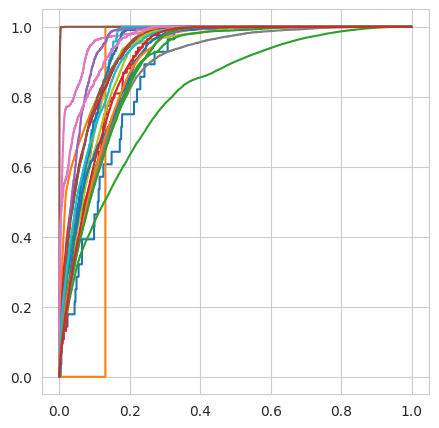

0.9172530534187869

auc : 0.9725959866160354
auc : 0.9921767504975848
auc : 0.8133130720561234
auc : 0.9418078117879272
auc : 0.8962481206125562
auc : 0.9996907600147876
auc : 0.9750982482539411
auc : 0.9287385042744248
auc : 0.9248811742878452
auc : 0.9549482677869591
auc : 0.9448013517463567
auc : 0.9473072404230681
auc : 0.9000782789899998
auc : 0.9370769633217928
auc : 0.9570208541876031
auc : 0.9409233608000424
auc : 0.9652626518819416
auc : 0.8829367338559376
auc : 0.9177301213710958
auc : 0.9297775539680889
auc : 0.9117551916741067
auc : 0.9044819602452534
auc : 0.897116527408758
auc : 0.9091095629114173


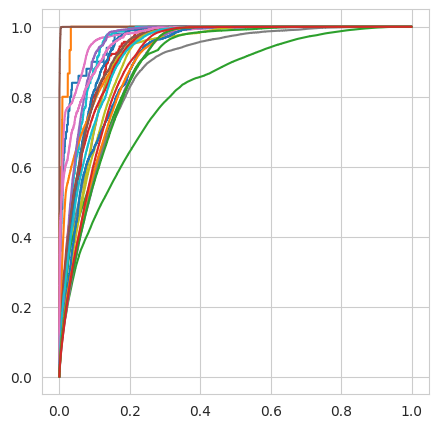

0.9310365437072354

In [77]:
# show_matrix()
# show_matrix(Yvalidation, y_pred)
show_roc(Ytest, y_pred_proba)
show_roc(Ytrain, train_pred_proba)

In [ ]:
 # GridSearch 寻找超参

param_test = {
    'max_depth': range(10, 31, 5),
    'n_estimators': range(10, 200, 20),
    # 'num_leaves': range(10, 40, 5),
}

gsc = GridSearchCV(
    estimator=m,
    param_grid=param_test,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    pre_dispatch=12,
    verbose=2
)
gsc.fit(Xtrain, Ytrain)

In [78]:
print(gsc.best_estimator_) # 最佳模型
print(gsc.best_score_)    #查看最佳分数(此处为f1_score)
print(gsc.best_params_)   #查看最佳参数
print(gsc.best_index_)
pd.DataFrame(gsc.cv_results_) # 所有训练结果


NameError: name 'gsc' is not defined

In [ ]:
sample_raw = pd.read_csv('../input/sample_submission.csv')
df_proba = pd.DataFrame(y_pred_proba)
df_proba.columns = Ytrain.columns

sample_raw['added_products'] = df_proba.idxmax(axis=1)
sample_raw.index = sample_raw.index + 1

sample_raw.to_csv('xgb.csv', index=False)

In [ ]:
Xtrain.shape

In [ ]:
import joblib

# Save to file in the current working directory
joblib_file = "joblib_model.pkl"
joblib.dump(m, joblib_file)

In [ ]:
load_model = joblib.load("joblib_model.pkl")